In [10]:
import numpy as np
import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import json
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2
import os
import statsmodels.api as sm

%matplotlib inline

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

### Load PCA

In [3]:
t0 = time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
pca_spatial.shape = (4554, -1)
pca_spatial.shape = (4554, 128, 84, 49)
print('Duration: {}'.format(time()-t0))

Duration: 27.247077465057373


### Load Models

In [4]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/20191106_analysis/20191106_models.json'
with open(file) as json_file:
    models = json.load(json_file)

### Reconstruct temporal brain

In [5]:
pca_loadings_std = np.std(pca_loadings,axis=0)
pca_loadings = np.divide(pca_loadings,pca_loadings_std)

In [6]:
# Get correct model
for model in models:
    if model['fly'] == 'fly_19':
        if model['num_pcs'] == 500:
            model_ = model

In [7]:
# I think this is the right way to reconstruct the brain.

temporal_weights_Y = np.multiply(model_['coef_Y'], pca_loadings[:,:500])
#reconstructed_brain_Y = np.tensor3dot(temporal_weights_Y, pca_spatial[:500,:,:,:],axes=1)

temporal_weights_Z = np.multiply(model_['coef_Z'], pca_loadings[:,:500])
#reconstructed_brain_Z = np.tensordot(temporal_weights_Z, pca_spatial[:500,:,:,:],axes=1)

### Perform tSNE!

In [9]:
temporal_weights_Y.shape

(4554, 500)

In [10]:
from sklearn.manifold import TSNE

In [52]:
X_tSNE = pca_loadings[:,:50]

In [53]:
X_tSNE.shape

(4554, 50)

In [39]:
t0 = time.time()

embedded_100 = TSNE(n_components=2,
                            perplexity=100).fit_transform(X_tSNE)
print('Duration: {:0.0f}s'.format(time.time()-t0))

Duration: 230s


In [60]:
perplexities = [10,30,50,70,90,110]
#perplexities = [30]

In [61]:
t0 = time.time()
embedded_raw = {}

for perplexity in perplexities:
    embedded_raw[perplexity] = TSNE(n_components=2,
                                perplexity=perplexity,
                                   learning_rate=200).fit_transform(X_tSNE)
    print('Duration: {:0.0f}s'.format(time.time()-t0))

Duration: 65s
Duration: 181s
Duration: 340s
Duration: 525s
Duration: 751s
Duration: 1007s


In [25]:
import json
newdir = os.path.join(directory,'tsne')
#os.mkdir(newdir)
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(newdir, timestr + '.npy')
with open(fname , 'w') as file:
    json.dump(embedded[50].tolist(),file)

In [14]:
import time

In [36]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

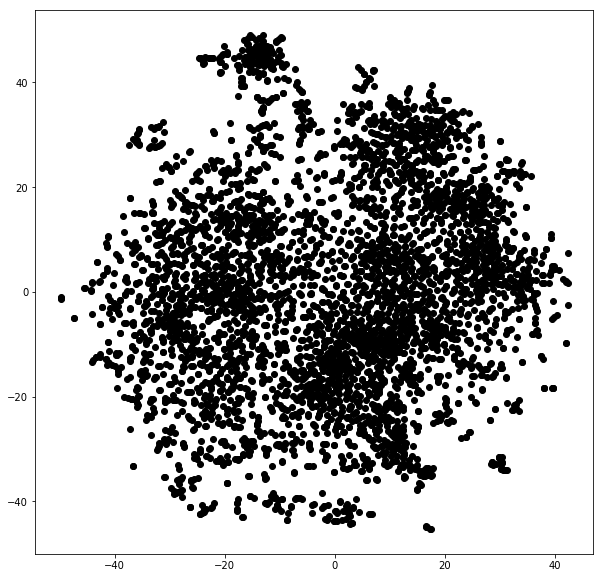

In [71]:
plt.figure(figsize=(10,10))
plt.plot(embedded_raw[70][:,0],
         embedded_raw[70][:,1],
         linestyle='None',
        color='k',
        marker='o')
#timestr = time.strftime("%Y%m%d-%H%M%S")
#fname = os.path.join(save_path, timestr + '_tsne_raw50zscorePCs.png'.format(i))
#plt.savefig(fname,dpi=300,bbox_inches='tight')

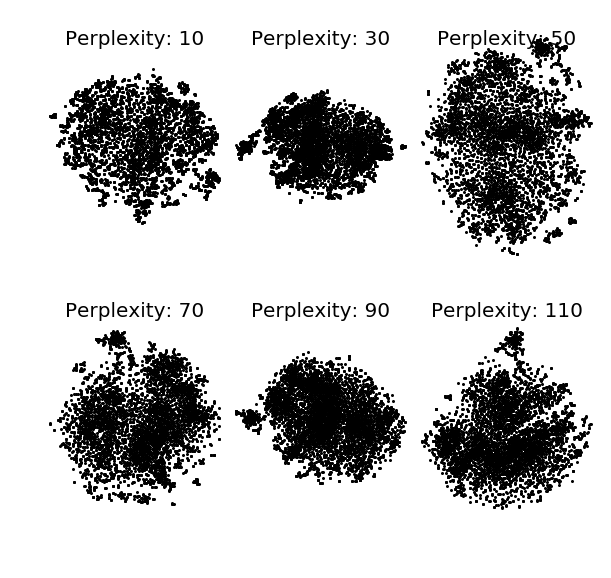

In [63]:
plt.figure(figsize=(10,10))
#perplexity = 50
for i,perplexity in enumerate(perplexities):
    plt.subplot(2,3,i+1)
    plt.plot(embedded_raw[perplexity][:,0],
             embedded_raw[perplexity][:,1],
             linestyle='None',marker='o',
             markersize=2,color='k')
    plt.axis('equal')
    plt.axis('off')
    plt.title('Perplexity: {}'.format(perplexity),y=.85,fontsize=20)
plt.subplots_adjust(wspace=0,hspace=0)
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '_tsne_perplexity_raw50Pcs.png'.format(i))
plt.savefig(fname,dpi=300,bbox_inches='tight')

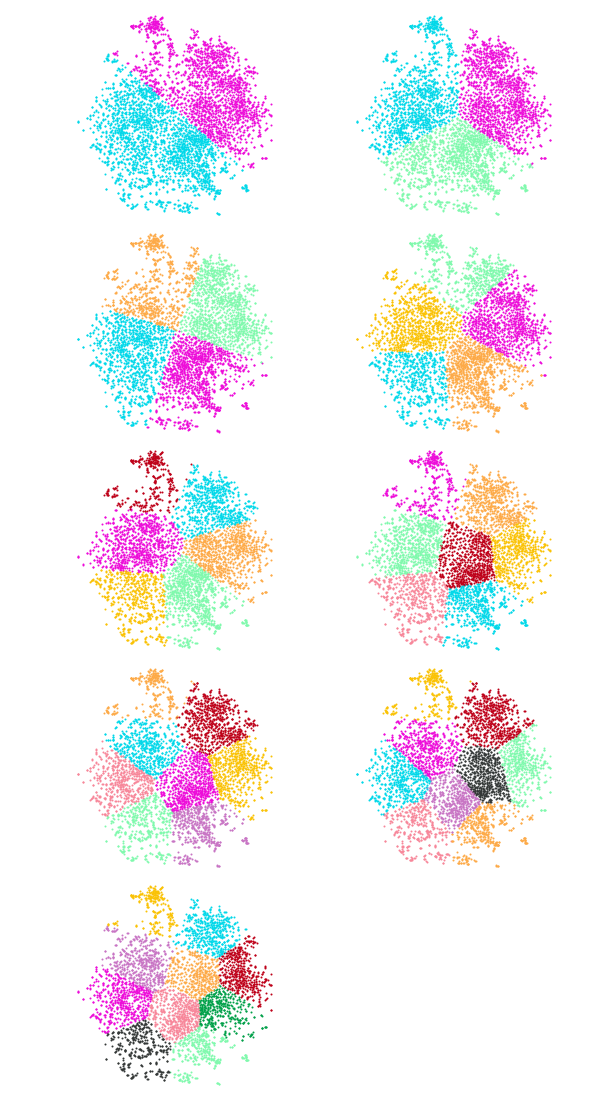

In [82]:
plt.figure(figsize=(10,20))
colors = ['xkcd:aqua blue', 'xkcd:fuchsia', 'xkcd:seafoam',
          'xkcd:light orange', 'xkcd:goldenrod', 'xkcd:scarlet',
          'xkcd:rose pink', 'xkcd:orchid', 'xkcd:charcoal',
          'xkcd:emerald']
for w,j in enumerate(n_clusters):
    ax = plt.subplot(5,2,w+1)
    for i in range(len(embedded_raw[70][:,0])):
        ax.plot(embedded_raw[70][i,0],
                   embedded_raw[70][i,1],
                   linestyle='None',
                   marker='o',
                   markersize=1,
                   color=colors[kmeans_raw[j].labels_[i]])
        ax.axis('equal')
        ax.axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '_tsne70onrawpc_kmeansontsne.png'.format(i))
plt.savefig(fname,dpi=300,bbox_inches='tight')

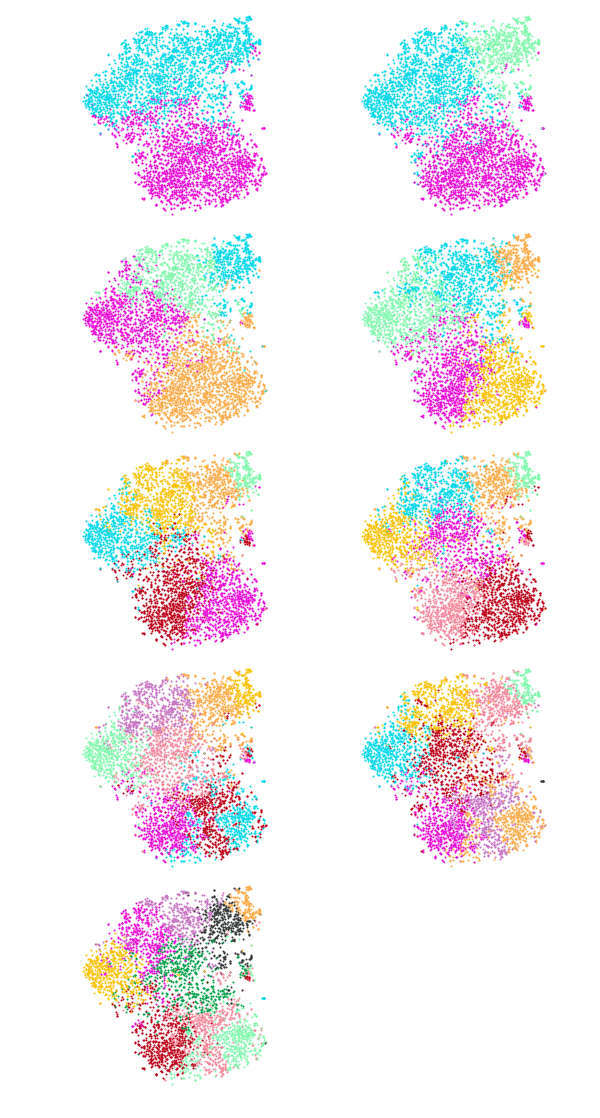

In [37]:
plt.figure(figsize=(10,20))
colors = ['xkcd:aqua blue', 'xkcd:fuchsia', 'xkcd:seafoam',
          'xkcd:light orange', 'xkcd:goldenrod', 'xkcd:scarlet',
          'xkcd:rose pink', 'xkcd:orchid', 'xkcd:charcoal',
          'xkcd:emerald']
for w,j in enumerate(n_clusters):
    ax = plt.subplot(5,2,w+1)
    for i in range(len(embedded[perplexity][:,0])):
        ax.plot(embedded[perplexity][i,0],
                   embedded[perplexity][i,1],
                   linestyle='None',
                   marker='o',
                   markersize=1,
                   color=colors[kmeans[j].labels_[i]])
        ax.axis('equal')
        ax.axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '_tsne50_kmeans_on_pcs.png'.format(i))
plt.savefig(fname,dpi=300,bbox_inches='tight')

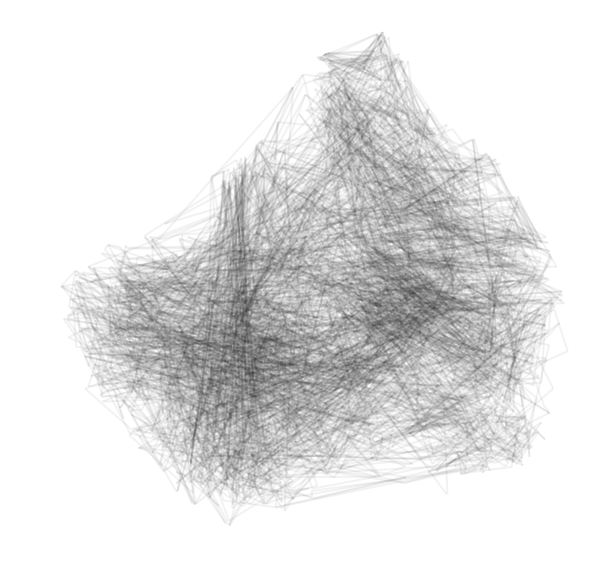

In [65]:
plt.figure(figsize=(10,10))
perplexity = 50
ax1 = plt.subplot(111)
x = embedded[perplexity][:,0]
y = embedded[perplexity][:,1]
ax1.axis('off')
for i in range(len(x)-1):
    ax1.plot(x[i:i+2],
             y[i:i+2],
             alpha=0.05,
             lw=2,
             solid_capstyle='butt',
             c='k')
    
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '_tsne_transitions.png'.format(i))
plt.savefig(fname,dpi=300,bbox_inches='tight')

### Kmeans!

In [8]:
from sklearn.cluster import KMeans

In [34]:
n_clusters = [2,3,4,5,6,7,8,9,10]
X = temporal_weights_Z
kmeans_Z = {}
for n_cluster in n_clusters:
    t0 = time.time()
    kmeans_Z[n_cluster] = KMeans(n_cluster).fit(X)
    print('Duration: {:0.0f}s'.format(time.time()-t0))

Duration: 1s
Duration: 2s
Duration: 3s
Duration: 4s
Duration: 3s
Duration: 4s
Duration: 5s
Duration: 5s
Duration: 5s


In [72]:
X_tSNE.shape

(4554, 50)

In [75]:
X_kmeans = embedded_raw[70]

In [76]:
n_clusters = [2,3,4,5,6,7,8,9,10]
kmeans_raw={}
for n_cluster in n_clusters:
    t0 = time.time()
    kmeans_raw[n_cluster] = KMeans(n_cluster).fit(X_kmeans)
    print('Duration: {:0.0f}s'.format(time.time()-t0))

Duration: 0s
Duration: 0s
Duration: 0s
Duration: 0s
Duration: 0s
Duration: 0s
Duration: 0s
Duration: 0s
Duration: 0s


In [73]:
embedded_raw[70].shape

(4554, 2)

# Compare clusters with behavior

### Load fictrac and timestamps

In [14]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 61.20 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.95 sec


### Process fictrac

In [15]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [16]:
resolution = 20 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

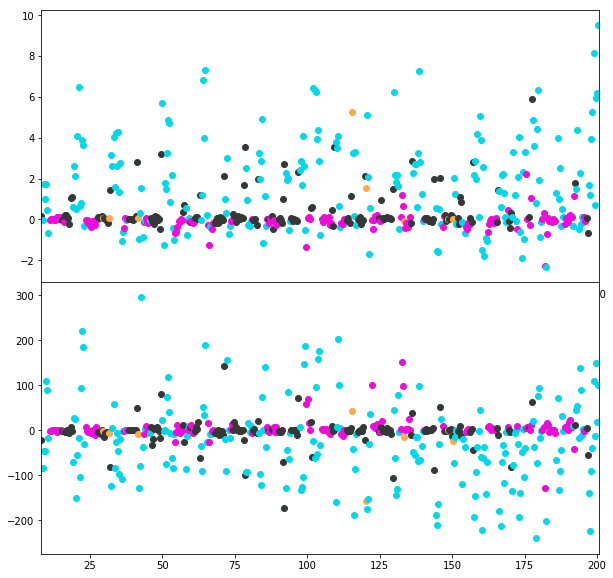

In [43]:
plt.figure(figsize=(10,10))

colors = ['xkcd:aqua blue', 'xkcd:fuchsia',
          'xkcd:light orange',  'xkcd:charcoal', 'xkcd:emerald',
          'xkcd:goldenrod', 'xkcd:scarlet',
          'xkcd:rose pink', 'xkcd:orchid',
          'xkcd:seafoam']

xs = timestamps[:,20]/1000

n_clusters = 4

ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2,sharex=ax1)

start = 20 # in sec
end = start + 8*60
#ax1.plot(xs,fictracs['Y'],color='k',linestyle='--')
for i in range(start,end):
    
    ax1.scatter(xs[i], fictracs['Y'][i],
             c=colors[kmeans_Y[n_clusters].labels_[i]])
    ax2.scatter(xs[i], fictracs['Z'][i],
             c=colors[kmeans_Y[n_clusters].labels_[i]])
    #ax2.plot(xs[i:i+2],
    #         fictracs['Z'][i:i+2],
    #         c=colors[kmeans_Y[n_clusters].labels_[i]])
ax1.set_xlim(xs[start],xs[end])
plt.subplots_adjust(wspace=0,hspace=0)

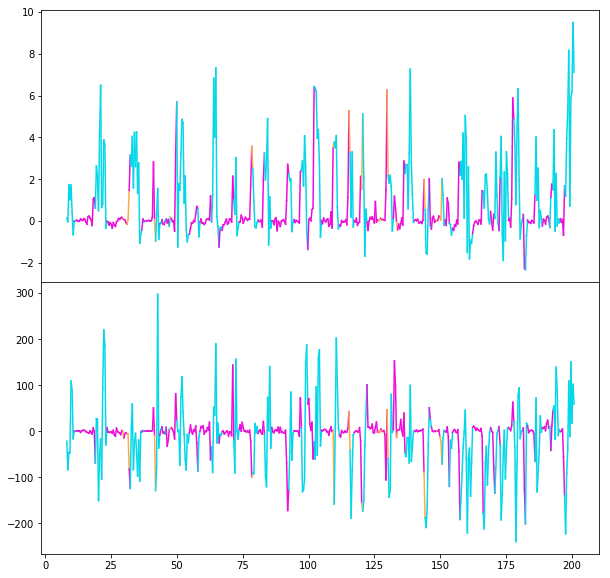

In [17]:
plt.figure(figsize=(10,10))

colors = ['xkcd:aqua blue', 'xkcd:fuchsia',
          'xkcd:light orange',  'xkcd:charcoal', 'xkcd:emerald',
          'xkcd:goldenrod', 'xkcd:scarlet',
          'xkcd:rose pink', 'xkcd:orchid',
          'xkcd:seafoam']

xs = timestamps[:,20]/1000

n_clusters = 3

ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2,sharex=ax1)

start = 20
end = start + 8*60

for i in range(start,end):
    ax1.plot(xs[i:i+2],
             fictracs['Y'][i:i+2],
             c=colors[kmeans_Y[n_clusters].labels_[i]])
    ax2.plot(xs[i:i+2],
             fictracs['Z'][i:i+2],
             c=colors[kmeans_Y[n_clusters].labels_[i]])

plt.subplots_adjust(wspace=0,hspace=0)

In [113]:
len(xs)

4554

In [ ]:
i=0
fictracs['Y'][i:i+2]

In [109]:
fictracs['Y'][0:2]

array([0.01666164, 0.01778675])

In [111]:
len(fictracs['Y'])

4554

In [112]:
len(kmeans[2].labels_)

4554